In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

In [ ]:
!mv drive/MyDrive/Dataset.zip .
!mv drive/MyDrive/Patterns.zip .

In [ ]:
!unzip -q Dataset.zip -d ./dataset
!unzip -q Patterns.zip -d ./patterns

In [ ]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [ ]:
im = cv2.imread('dataset/1644369658.7214494.jpg')
pattern = cv2.imread('patterns/AYLIN.tif')

In [ ]:
def transform_image(im, pattern):
    assert im.shape == pattern.shape
    orb = cv2.ORB_create(nfeatures=500)
    kp1, des1 = orb.detectAndCompute(im, None)
    kp2, des2 = orb.detectAndCompute(pattern,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance, reverse=False)
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt

    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    height, width, channels = pattern.shape
    warped = cv2.warpPerspective(im, h, (width, height))
    return warped, h

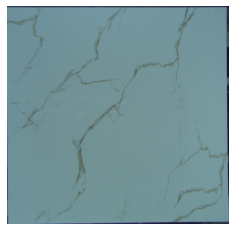

In [ ]:
pattern = cv2.resize(pattern, im.shape[:2][::-1])
warped, transform = transform_image(im, pattern)
imshow(warped)

In [ ]:
def get_segmentation(image, transform, data):
    segmentation = np.zeros_like(image).astype(np.float32)
    for shape in data['shapes']:
        points = np.array(shape['points'])
        cv2.fillPoly(segmentation, pts=[points.astype(np.int32)], color=(255, 255, 255))
    height, width, channels = image.shape
    warped_segmentation = cv2.warpPerspective(segmentation, transform, (width, height))
    return segmentation

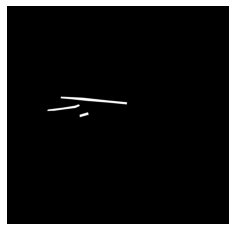

In [ ]:
with open('dataset/1644369658.7214494.json') as f:
        data = json.load(f)
imshow(get_segmentation(im, transform, data))

In [ ]:
images = []
segments = []

for path in np.sort(glob.glob('dataset/*.json')):
    with open(path) as f:
        data = json.load(f)
    image = cv2.imread(f'dataset/{data["imagePath"]}')
    pattern = cv2.imread(f'patterns/{data["pattern"]}')
    pattern = cv2.resize(pattern, image.shape[:2][::-1])
    warped, transform = transform_image(image, pattern)
    segment = cv2.cvtColor(get_segmentation(warped, transform, data), cv2.COLOR_BGR2GRAY)
    segment = cv2.threshold(segment, 127, 1, cv2.THRESH_BINARY)[1]
    warped = cv2.resize(warped, (256, 256))
    pattern = cv2.resize(pattern, (256, 256))
    segment = cv2.resize(segment, (256, 256))
    segment = segment.reshape((segment.shape[0], segment.shape[1], 1))
    image = np.concatenate((warped, pattern), axis=-1)
    images.append(image)
    segments.append(segment)

images = np.array(images)
segments = np.array(segments)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, segments, test_size=0.1, random_state=42)
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [ ]:
def double_conv_block(x, n_filters):
   x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
   x = keras.layers.BatchNormalization()(x)
   x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
   x = keras.layers.BatchNormalization()(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = keras.layers.MaxPool2D(2)(f)
   p = keras.layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = keras.layers.concatenate([x, conv_features])
   x = keras.layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model(): 
   inputs = keras.layers.Input(shape=(256, 256 ,6))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)
   bottleneck = double_conv_block(p4, 1024)
   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)
   c = keras.layers.Conv2D(1, 1, padding="valid")(u9)
   bn_c = keras.layers.BatchNormalization()(c)
   outputs = keras.layers.Activation('sigmoid')(bn_c)
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  3520        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [ ]:
unet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = unet_model.fit(X_train, y_train,
                         batch_size=8,
                         validation_data=[X_test, y_test],
                         epochs=10)

Epoch 1/10
35/35 [==============================] - 25s 628ms/step - loss: 0.2067 - accuracy: 0.2605 - val_loss: 10.1782 - val_accuracy: 0.9985
Epoch 2/10
35/35 [==============================] - 21s 603ms/step - loss: 0.1726 - accuracy: 0.5215 - val_loss: 2.2545 - val_accuracy: 0.9667
Epoch 3/10
35/35 [==============================] - 21s 597ms/step - loss: 0.1596 - accuracy: 0.8538 - val_loss: 0.2253 - val_accuracy: 0.3207
Epoch 4/10
35/35 [==============================] - 21s 599ms/step - loss: 0.1483 - accuracy: 0.9563 - val_loss: 0.1020 - val_accuracy: 0.9840
Epoch 5/10
35/35 [==============================] - 21s 603ms/step - loss: 0.1433 - accuracy: 0.9576 - val_loss: 1.2860 - val_accuracy: 0.5721
Epoch 6/10
35/35 [==============================] - 21s 602ms/step - loss: 0.1324 - accuracy: 0.9812 - val_loss: 0.1112 - val_accuracy: 0.8211
Epoch 7/10
35/35 [==============================] - 21s 598ms/step - loss: 0.1253 - accuracy: 0.9945 - val_loss: 0.1194 - val_accuracy: 0.998

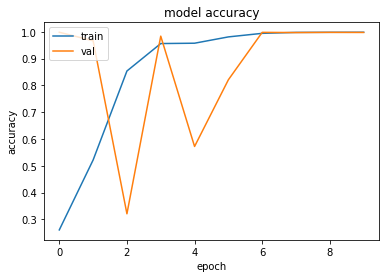

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

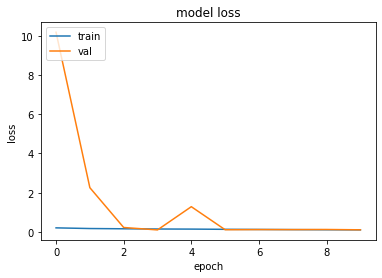

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_json = unet_model.to_json()
with open("drive/MyDrive/unet_cv.json", "w") as json_file:
    json_file.write(model_json)
unet_model.save('drive/MyDrive/unet_cv.h5')

In [ ]:
def predict(image, pattern):
    json_file = open('drive/MyDrive/unet_cv.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights("drive/MyDrive/unet_cv.h5")
    loaded_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryFocalCrossentropy(),
        metrics=['accuracy']
    )
    pattern = cv2.resize(pattern, image.shape[:2][::-1])
    warped, transform = transform_image(image, pattern)
    warped = cv2.resize(warped, (256, 256))
    pattern = cv2.resize(pattern, (256, 256))
    x = np.concatenate((warped, pattern), axis=-1)
    return loaded_model.predict(np.array([x,]))[0].reshape(256, 256)